In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
# This is need so you can import larndsim without doing python setup.py install
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mpl_toolkits.mplot3d.art3d as art3d

import numpy as np
import eagerpy as ep
import h5py

import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 100

In [4]:
from numpy.lib import recfunctions as rfn
import torch

def torch_from_structured(tracks):
    tracks_np = rfn.structured_to_unstructured(tracks, copy=True, dtype=np.float32)
    return torch.from_numpy(tracks_np).float()

def structered_from_torch(tracks_torch, dtype):
    return rfn.unstructured_to_structured(tracks_torch.cpu().numpy(), dtype=dtype)

### Dataset import
First of all we load the `edep-sim` output. For this sample we need to invert $z$ and $y$ axes.

In [5]:
# If you have access to a GPU, sim works trivially/is much faster
if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    device = 'cpu'

In [6]:
dir_name = '/sdf/group/neutrino/kvtsang/nd-sim/test-samples/2021-11-08/'
fname = dir_name + 'edepsim.h5'
with h5py.File(fname, 'r') as f:
    tracks = np.array(f['segments'])  

x_start = np.copy(tracks['x_start'] )
x_end = np.copy(tracks['x_end'])
x = np.copy(tracks['x'])

tracks['x_start'] = np.copy(tracks['z_start'])
tracks['x_end'] = np.copy(tracks['z_end'])
tracks['x'] = np.copy(tracks['z'])

tracks['z_start'] = x_start
tracks['z_end'] = x_end
tracks['z'] = x

selected_tracks = tracks[0:20]
selected_tracks_torch = torch_from_structured(np.copy(selected_tracks)).to(device)

In [7]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for trk in range(len(selected_tracks)):
    ax.plot([selected_tracks[trk]['x_start'], selected_tracks[trk]['x_end']],
            [selected_tracks[trk]['y_start'], selected_tracks[trk]['y_end']],
            [selected_tracks[trk]['z_start'], selected_tracks[trk]['z_end']])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#pickle.dump(fig, open('input_tracks.pickle', 'wb'))
plt.show()

<IPython.core.display.Javascript object>

## Simulation
To flexibly keep track of parameters/gradients, simulations are housed in a class `sim_with_grad`. This is derived from class versions of all the other modules. Parameters are housed in `consts`, with method `track_gradients` to promote the constants to `requires_grad=True` PyTorch tensors.

In [7]:
from larndsim.sim_with_grad import sim_with_grad

Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.pixel_trim_dac using bits (0, 512)
	<function _list_property at 0x7f40e11981f0>((<class 'int'>, 0, 31, 64, 8)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.threshold_global using bits (512, 520)
	<function _basic_property at 0x7f40e1198160>((<class 'int'>, 0, 255)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_gain using bits (520, 521)
	<function _compound_property at 0x7f40e1198280>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.csa_bypass_enable using bits (521, 522)
	<function _compound_property at 0x7f40e1198280>((['csa_gain', 'csa_bypass_enable', 'bypass_caps_en'], (<class 'int'>, <class 'bool'>), 0, 1)) 
Generate <class 'larpix.configuration.configuration_v2b.Configuration_v2b'>.bypass_caps_en using bits (522, 523)
	

## The simulation
Following the flow of the simulation chain, define a function which takes in the `sim_with_grad` object, runs whatever pieces of the simulation, and returns desired output.

In [8]:
# Here we build a map between tracks and event IDs (no param dependence, so np should be ok)
unique_eventIDs = np.unique(selected_tracks['eventID'])
event_id_map = np.searchsorted(unique_eventIDs,np.asarray(selected_tracks['eventID']))
event_id_map_torch = torch.from_numpy(event_id_map).to(device)

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def all_sim(sim, selected_tracks, fields, event_id_map, return_unique_pix=False):
    selected_tracks_quench = sim.quench(selected_tracks, sim.birks, fields=fields)
    selected_tracks_drift = sim.drift(selected_tracks_quench, fields=fields)

    active_pixels_torch, neighboring_pixels_torch, n_pixels_list_ep = sim.get_pixels(selected_tracks_drift,
                                                                                     fields=fields)

    track_starts_torch, max_length_torch = sim.time_intervals(event_id_map_torch, 
                                                              selected_tracks_drift, 
                                                              fields=fields)
    
    signals_ep = sim.tracks_current(neighboring_pixels_torch, selected_tracks_drift, 
                                          max_length_torch,
                                          fields=fields)

    unique_pix_torch = torch.empty((0, 2))
    pixels_signals_torch = torch.zeros((len(unique_pix_torch), len(sim.time_ticks)*5))

    shapes_torch = neighboring_pixels_torch.shape
    joined_torch = neighboring_pixels_torch.reshape(shapes_torch[0]*shapes_torch[1], 2)

    this_unique_pix_torch = torch.unique(joined_torch, dim=0)
    this_unique_pix_torch = this_unique_pix_torch[(this_unique_pix_torch[:,0] != -1) & (this_unique_pix_torch[:,1] != -1),:]
    unique_pix_torch = torch.cat((unique_pix_torch, this_unique_pix_torch),dim=0)

    this_pixels_signals_torch = torch.zeros((len(this_unique_pix_torch), len(sim.time_ticks)*5))
    pixels_signals_torch = torch.cat((pixels_signals_torch, this_pixels_signals_torch), dim=0)

    pixel_index_map_torch = torch.full((selected_tracks.shape[0], neighboring_pixels_torch.shape[1]), -1)
    compare_torch = (neighboring_pixels_torch[..., np.newaxis, :] == unique_pix_torch)

    indices_torch = torch.where(torch.logical_and(compare_torch[..., 0], compare_torch[...,1]))
    pixel_index_map_torch[indices_torch[0], indices_torch[1]] = indices_torch[2]
    
    pixels_signals_torch = sim.sum_pixel_signals(pixels_signals_torch,
                                                 signals_ep,
                                                track_starts_torch,
                                                pixel_index_map_torch)
    
    time_ticks_torch = torch.linspace(0, len(unique_eventIDs)*sim.time_interval[1]*3, pixels_signals_torch.shape[1]+1)

    integral_list_torch, adc_ticks_list_torch = sim.get_adc_values(pixels_signals_torch,
                                                                   time_ticks_torch,
                                                                   0)
    adc_list_torch = sim.digitize(integral_list_torch)

    if return_unique_pix:
        return adc_list_torch, unique_pix_torch
    else:
        return adc_list_torch

In [10]:
# Update parameters for training loop
def update_grad_param(sim, name, value):
    setattr(sim, name, value)
    sim.track_gradients([name])

In [11]:
# ADC counts given as list of pixels. Better for loss to embed this in the "full" pixel space
def embed_adc_list(sim, adc_list, unique_pix):
    zero_val = sim.digitize(torch.tensor(0)).item()
    new_list = torch.ones((sim.n_pixels[0], sim.n_pixels[1], adc_list.shape[1]))*zero_val

    plane_id = unique_pix[..., 0] // sim.n_pixels[0]
    unique_pix[..., 0] = unique_pix[..., 0] - sim.n_pixels[0] * plane_id

    new_list[unique_pix[:, 0].long(), unique_pix[:, 1].long(), :] = adc_list
    
    return new_list

## Experiment: pseudo-data
1. Construct dataset with one set of parameters
2. Initialize parameters to something else
3. See if we can recover default parameters

In [13]:
#Simulate with defaults: in particular, eField == 0.5
sim_default = sim_with_grad()
sim_default.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")
target, pix_target = all_sim(sim_default, selected_tracks_torch, selected_tracks.dtype.names, 
                             event_id_map_torch, return_unique_pix=True)

embed_target = embed_adc_list(sim_default, target, pix_target)

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
<ipython-input-12-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It current

In [14]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [ ]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize eField to different value
eField_init = 0.1
update_grad_param(sim, "eField", eField_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.Adam([sim.eField], lr=0.01)#, momentum=0.1)

training_step_eFields = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(800):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    
    optimizer.step()
    
    if epoch % 50 == 0:
        print(f"eField for epoch {epoch}, {sim.eField} [kV / cm]")
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

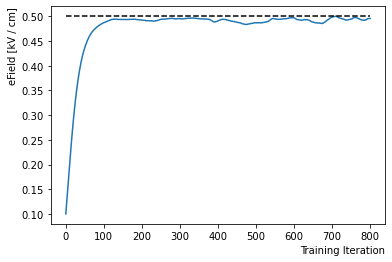

In [17]:
%matplotlib inline
plt.plot([0.1]+training_step_eFields)
plt.plot([0.5]*(len(training_step_eFields)+1), ls='dashed', c='k')
plt.ylabel('eField [kV / cm]', ha='right', y=1.0)
plt.xlabel('Training Iteration', ha='right', x=1.0)
plt.savefig('efield_convergence_ADC.pdf')
plt.show()

Final value is slightly high, but quite close (< 5% error). Likely comparable with true value within noise, to be checked.

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


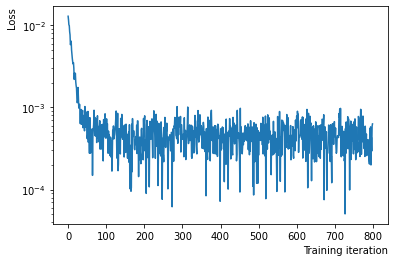

In [18]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.savefig('efield_loss_ADC.pdf')
plt.show()

## Repeat 1 parameter fit for lifetime

In [19]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize lifetime to different value
lifetime_init = 300
update_grad_param(sim, "lifetime", lifetime_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.Adam([sim.lifetime], lr=7e1)#, momentum=0.01)

training_step_lifetimes = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    #print(sim.lifetime)
    optimizer.step()
    #print(sim.lifetime.grad)
    if epoch % 50 == 0:
        print(f"Lifetime for epoch {epoch}, {sim.lifetime} $\\mu s$")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


Lifetime for epoch 0, 369.9151611328125 $\mu s$
Lifetime for epoch 50, 1355.5838623046875 $\mu s$
Lifetime for epoch 100, 1503.288330078125 $\mu s$
Lifetime for epoch 150, 1612.3682861328125 $\mu s$
Lifetime for epoch 200, 1689.9578857421875 $\mu s$
Lifetime for epoch 250, 1733.7569580078125 $\mu s$
Lifetime for epoch 300, 1787.1705322265625 $\mu s$
Lifetime for epoch 350, 1833.0418701171875 $\mu s$
Lifetime for epoch 400, 1869.6329345703125 $\mu s$
Lifetime for epoch 450, 1917.4847412109375 $\mu s$
Lifetime for epoch 500, 1954.228759765625 $\mu s$
Lifetime for epoch 550, 1966.3690185546875 $\mu s$
Lifetime for epoch 600, 1953.2777099609375 $\mu s$
Lifetime for epoch 650, 1942.28173828125 $\mu s$
Lifetime for epoch 700, 1942.040771484375 $\mu s$
Lifetime for epoch 750, 1969.63671875 $\mu s$
Lifetime for epoch 800, 1965.003173828125 $\mu s$
Lifetime for epoch 850, 1975.1385498046875 $\mu s$
Lifetime for epoch 900, 1982.500244140625 $\mu s$
Lifetime for epoch 950, 1970.78564453125 $\mu s

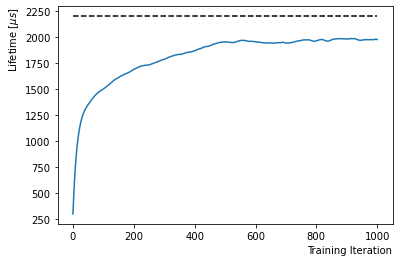

In [21]:
plt.plot([300]+training_step_lifetimes)
plt.plot([2200]*(len(training_step_lifetimes)+1), ls='dashed', c='k')
plt.ylabel('Lifetime [$\\mu s$]', ha='right', y=1.0)
plt.xlabel('Training Iteration', ha='right', x=1.0)
plt.savefig('lifetime_convergence_ADC.pdf')
plt.show()

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


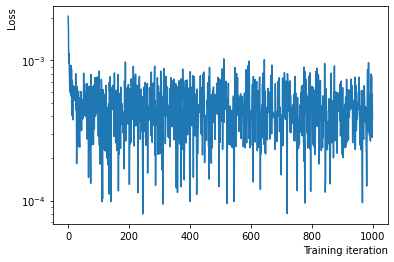

In [22]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.savefig('lifetime_loss_ADC.pdf')
plt.show()

Training doesn't quite converge to the target value

In [23]:
training_step_lifetimes[-1].item(), sim_default.lifetime

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1976.3277587890625, 2200.0)

Let's check how compatible things are by sampling losses at each value

In [24]:
losses_conv = []
sim.lifetime=training_step_lifetimes[-1].item()
for check in range(300):
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)

    embed_output = embed_adc_list(sim, output, pix_out)

    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    losses_conv.append(loss.item())

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


In [25]:
losses_target = []
sim.lifetime=2200.
for check in range(300):
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)

    embed_output = embed_adc_list(sim, output, pix_out)

    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    losses_target.append(loss.item())

<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


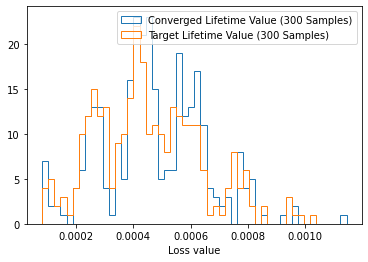

In [26]:
_, bins, _ = plt.hist(losses_conv, bins=50, histtype='step', label='Converged Lifetime Value (300 Samples)')
plt.hist(losses_target, bins=bins, histtype='step', label='Target Lifetime Value (300 Samples)')
plt.legend()
plt.xlabel('Loss value')
plt.savefig('check_lifetime_compatibility.pdf')
plt.show()

Large amount of overlap in these distributions -- we're fitting to a _single_ random sample when we do this fit!

## Try 2 parameter fit? (lifetime and eField)

In [27]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize both lifetime and eField to different value
lifetime_init = 1000
eField_init = 0.1
update_grad_param(sim, "lifetime", lifetime_init)
update_grad_param(sim, "eField", eField_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([{ 'params' : [sim.lifetime], 'lr' : 2e7},
                             { 'params' : [sim.eField], 'lr' : 0.2}])
                            #], momentum=0.01)

training_step_lifetimes = []
training_step_eFields = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(2000):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    #print(sim.lifetime, sim.eField)
    optimizer.step()
    #print(sim.lifetime.grad, sim.eField.grad)
    if epoch % 50 == 0:
        print(f"Lifetime for epoch {epoch}, {sim.lifetime} $\\mu s$, {sim.eField} [kV / cm]")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


Lifetime for epoch 0, 1008.29833984375 $\mu s$, 0.10539501905441284 [kV / cm]
Lifetime for epoch 50, 1485.8189697265625 $\mu s$, 0.3052064776420593 [kV / cm]
Lifetime for epoch 100, 1701.3798828125 $\mu s$, 0.37839674949645996 [kV / cm]
Lifetime for epoch 150, 1820.579833984375 $\mu s$, 0.4176750183105469 [kV / cm]
Lifetime for epoch 200, 1895.0240478515625 $\mu s$, 0.44198164343833923 [kV / cm]
Lifetime for epoch 250, 1943.43798828125 $\mu s$, 0.4576302170753479 [kV / cm]
Lifetime for epoch 300, 1977.069580078125 $\mu s$, 0.4685245752334595 [kV / cm]
Lifetime for epoch 350, 2003.5321044921875 $\mu s$, 0.4770260155200958 [kV / cm]
Lifetime for epoch 400, 2020.4912109375 $\mu s$, 0.4823419153690338 [kV / cm]
Lifetime for epoch 450, 2031.5125732421875 $\mu s$, 0.48573219776153564 [kV / cm]
Lifetime for epoch 500, 2039.799072265625 $\mu s$, 0.48817500472068787 [kV / cm]
Lifetime for epoch 550, 2048.2265625 $\mu s$, 0.49076175689697266 [kV / cm]
Lifetime for epoch 600, 2052.805419921875 $\

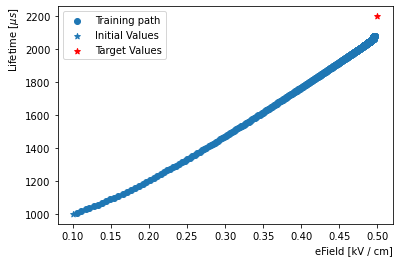

In [29]:
plt.scatter(training_step_eFields, training_step_lifetimes,
        label='Training path')
plt.scatter(eField_init, lifetime_init, c='C0', marker='*', label='Initial Values')
plt.scatter(0.5, 2200, marker='*', c='r', label='Target Values')
plt.xlabel('eField [kV / cm]', x=1.0, ha='right')
plt.ylabel('Lifetime [$\\mu s$]', y=1.0, ha='right')
plt.legend()
plt.savefig('lifetime_and_eField_convergence_ADC.pdf')
plt.show()

Two parameter fit converges to within ~5%

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


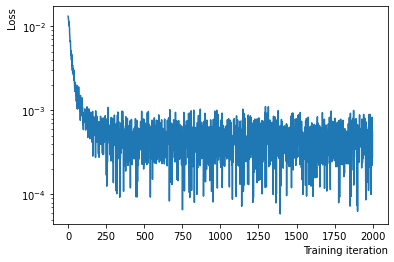

In [30]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.savefig('lifetime_and_eField_loss_ADC.pdf')
plt.show()

## Try 3 parameter fit? (lifetime, eField, drift velocity)

In [31]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize both lifetime and eField to different value
lifetime_init = 1000
eField_init = 0.1
vdrift_init = 0.1
update_grad_param(sim, "lifetime", lifetime_init)
update_grad_param(sim, "eField", eField_init)
update_grad_param(sim, "vdrift", vdrift_init)

# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([{ 'params' : [sim.lifetime], 'lr' : 2e7},
                             { 'params' : [sim.eField], 'lr' : 0.2},
                             {'params': [sim.vdrift], 'lr' : 0.004}])
                            #], momentum=0.01)

training_step_lifetimes = []
training_step_eFields = []
training_step_vdrifts = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    #print(sim.lifetime, sim.eField)
    optimizer.step()
    #print(sim.lifetime.grad, sim.eField.grad)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, {sim.lifetime} $\\mu s$, {sim.eField} [kV / cm], {sim.vdrift} cm / us")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_vdrifts.append(sim.vdrift.item())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


Epoch 0, 1013.633544921875 $\mu s$, 0.1055774837732315 [kV / cm], 0.10031737387180328 cm / us
Epoch 50, 1607.928466796875 $\mu s$, 0.3006051182746887 [kV / cm], 0.12320864945650101 cm / us
Epoch 100, 1857.214111328125 $\mu s$, 0.3815601170063019 [kV / cm], 0.13736821711063385 cm / us
Epoch 150, 1973.6578369140625 $\mu s$, 0.4207766354084015 [kV / cm], 0.14502811431884766 cm / us
Epoch 200, 2049.07568359375 $\mu s$, 0.44651123881340027 [kV / cm], 0.1501377522945404 cm / us
Epoch 250, 2104.687744140625 $\mu s$, 0.4655631482601166 [kV / cm], 0.1540841907262802 cm / us
Epoch 300, 2138.7412109375 $\mu s$, 0.47718292474746704 [kV / cm], 0.15665403008460999 cm / us
Epoch 350, 2153.081298828125 $\mu s$, 0.4820881485939026 [kV / cm], 0.15759031474590302 cm / us
Epoch 400, 2156.863037109375 $\mu s$, 0.4832710325717926 [kV / cm], 0.1577288657426834 cm / us
Epoch 450, 2165.097412109375 $\mu s$, 0.48614028096199036 [kV / cm], 0.1582898497581482 cm / us
Epoch 500, 2171.13037109375 $\mu s$, 0.4880686

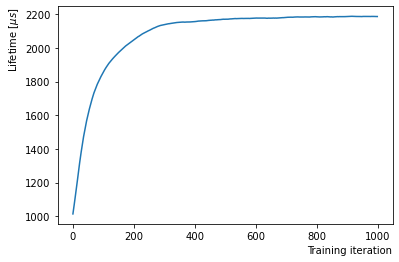

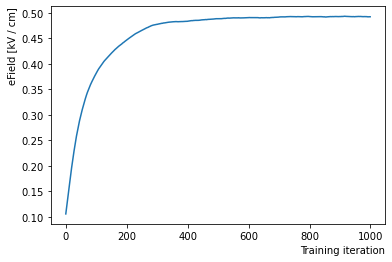

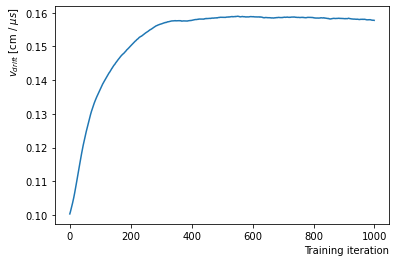

In [33]:
%matplotlib inline
plt.plot(np.arange(len(training_step_lifetimes)), training_step_lifetimes)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Lifetime [$\\mu s$]', ha='right', y=1.0)
plt.savefig('lifetime_convergence_3param_ADC.pdf')
plt.show()

plt.plot(np.arange(len(training_step_eFields)), training_step_eFields)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('eField [kV / cm]', ha='right', y=1.0)
plt.savefig('eField_convergence_3param_ADC.pdf')
plt.show()

plt.plot(np.arange(len(training_step_vdrifts)), training_step_vdrifts)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('$v_{drift}$ [cm / $\\mu s$]', ha='right', y=1.0)
plt.savefig('vdrift_convergence_3param_ADC.pdf')
plt.show()

In [36]:
import pickle

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


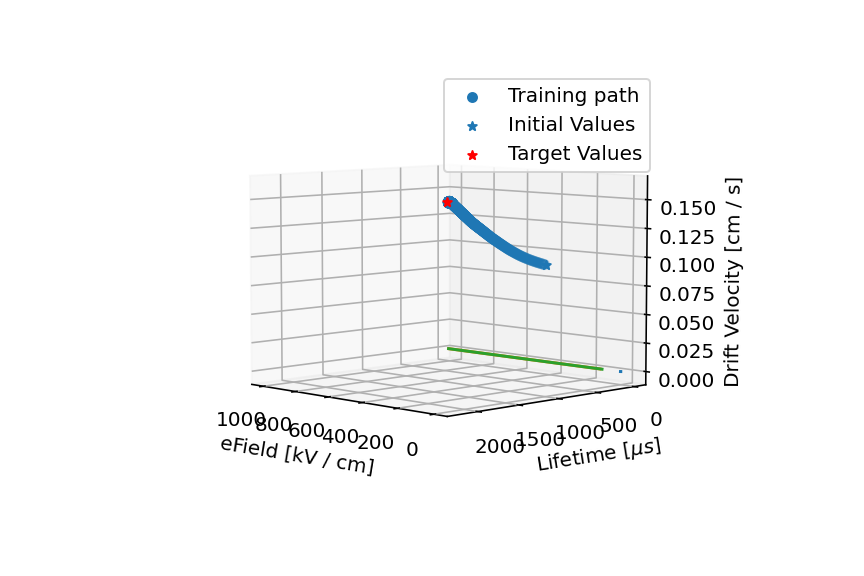

In [39]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(training_step_eFields, training_step_lifetimes, training_step_vdrifts,
        label='Training path')
ax.scatter(eField_init, lifetime_init, vdrift_init, c='C0', marker='*', label='Initial Values')
ax.scatter(0.5, 2200, 0.1587, marker='*', c='r', label='Target Values')
ax.set_xlabel('eField [kV / cm]', x=1.0, ha='right')
ax.set_ylabel('Lifetime [$\\mu s$]', y=1.0, ha='right')
ax.set_zlabel('Drift Velocity [cm / s]', y=1.0, ha='right')
plt.legend()
pickle.dump(fig, open('3param_fit_path.pickle', 'wb'))
plt.show()

Three parameter fit converges

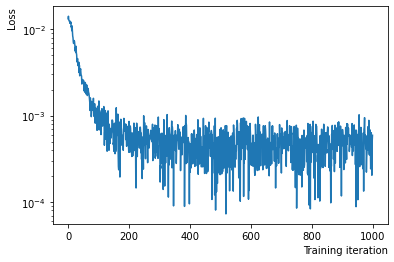

In [35]:
%matplotlib inline
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Loss', ha='right', y=1.0)
plt.savefig('3param_loss_ADC.pdf')
plt.show()

## WIP: add in equation from:
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.214.5944&rep=rep1&type=pdf
\begin{equation}
v(E, T) = [P_1 (T-T_0) + 1][P_3E\ln(1+\frac{P_{4}}{E}) + P_5 E^{P_6}] + P_{2}(T-T_0)
\end{equation}

In [17]:
def velocity(E):
    # Values from paper above
    p1 = 0.01481
    p2 = -0.0075
    p3 = 0.141
    p4 = 12.4
    p5 = 1.627
    p6 = 0.317
    T0 = 90.371
    
    # Value according to Kazu
    T = 87.3
    
    term1 = p1*(T-T0)+1
    term2 = p3*E*torch.log(1+p4/E) + p5*E**p6
    term3 = p2*(T-T0)
    
    result = term1*term2+term3
    
    #Units -- convert to cm/us
    return result/10.

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


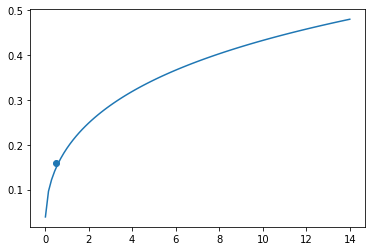

In [67]:
%matplotlib inline
test_E = torch.linspace(0.01, 14, 100)
plt.plot(test_E.cpu(), velocity(test_E).cpu())
plt.scatter(sim_default.eField, sim_default.vdrift)
plt.show()

In [61]:
velocity(0.5)

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.4884141855076218

In [18]:
#Setup simulation object for training
sim = sim_with_grad()
sim.load_detector_properties("../larndsim/detector_properties/module0.yaml",
                             "../larndsim/pixel_layouts/multi_tile_layout-2.2.16.yaml")

In [25]:
#Simple MSE loss between target and output
loss_fn = torch.nn.MSELoss()

#Initialize both lifetime and eField to different value
lifetime_init = 1000
eField_init = 0.1
update_grad_param(sim, "lifetime", lifetime_init)
update_grad_param(sim, "eField", eField_init)


# Should be smarter w/ lr, but for now eyeball given gradient
optimizer = torch.optim.SGD([{ 'params' : [sim.lifetime], 'lr' : 2.5e7},
                             { 'params' : [sim.eField], 'lr' : 0.2}])
                            #], momentum=0.01)

training_step_lifetimes = []
training_step_eFields = []
training_step_vdrifts = []
training_step_ADC = []
losses = []

#Training loop
for epoch in range(4000):
    optimizer.zero_grad()
    
    sim.vdrift = velocity(sim.eField)
    
    #Simulate with that parameter and get output
    output, pix_out = all_sim(sim, selected_tracks_torch, selected_tracks.dtype.names, event_id_map, 
                              return_unique_pix=True)
    
    embed_output = embed_adc_list(sim, output, pix_out)
    
    #Calc loss between simulated and target + backprop
    loss = loss_fn(embed_output, embed_target)
    loss.backward()
    
    #print(sim.lifetime, sim.eField, sim.vdrift)
    optimizer.step()
    #print(sim.lifetime.grad, sim.eField.grad)
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, {sim.lifetime} $\\mu s$, {sim.eField} [kV / cm], {sim.vdrift} cm / us")
    training_step_lifetimes.append(sim.lifetime.cpu().detach().numpy().copy())
    training_step_eFields.append(sim.eField.cpu().detach().numpy().copy())
    training_step_vdrifts.append(sim.vdrift.item())
    training_step_ADC.append(embed_output.cpu().detach())
    losses.append(loss.cpu().detach())

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/eagerpy/tensor/base.py:98: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return type(self)(self.raw.__floordiv__(unwrap1(other)))
<ipython-input-13-bf45e8c64373>:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  plane_id = unique_pix[..., 0] // sim.n_pixels[0]


Epoch 0, 1018.5872802734375 $\mu s$, 0.11100422590970993 [kV / cm], 0.08364810794591904 cm / us
Epoch 50, 1627.8505859375 $\mu s$, 0.39170560240745544 [kV / cm], 0.1357582062482834 cm / us
Epoch 100, 1768.043212890625 $\mu s$, 0.4488467276096344 [kV / cm], 0.1429927796125412 cm / us
Epoch 150, 1828.82275390625 $\mu s$, 0.46919047832489014 [kV / cm], 0.14537011086940765 cm / us
Epoch 200, 1865.1536865234375 $\mu s$, 0.4768402874469757 [kV / cm], 0.14624790847301483 cm / us
Epoch 250, 1887.385986328125 $\mu s$, 0.4769386649131775 [kV / cm], 0.1463261842727661 cm / us
Epoch 300, 1911.018798828125 $\mu s$, 0.4783601462841034 [kV / cm], 0.14642754197120667 cm / us
Epoch 350, 1927.488525390625 $\mu s$, 0.4767710268497467 [kV / cm], 0.14621330797672272 cm / us
Epoch 400, 1952.1553955078125 $\mu s$, 0.4786466062068939 [kV / cm], 0.14634369313716888 cm / us
Epoch 450, 1967.26318359375 $\mu s$, 0.4765327572822571 [kV / cm], 0.14622712135314941 cm / us
Epoch 500, 1986.575439453125 $\mu s$, 0.4762

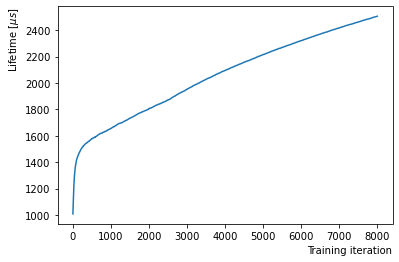

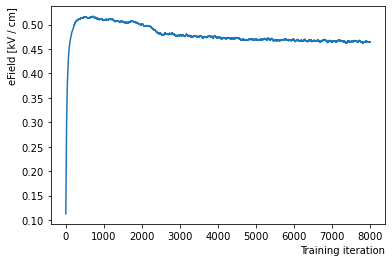

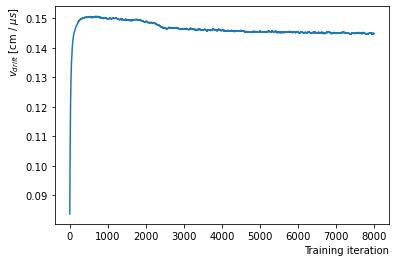

In [23]:
%matplotlib inline
plt.plot(np.arange(len(training_step_lifetimes)), training_step_lifetimes)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('Lifetime [$\\mu s$]', ha='right', y=1.0)
#plt.savefig('lifetime_convergence_3param_ADC.pdf')
plt.show()

plt.plot(np.arange(len(training_step_eFields)), training_step_eFields)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('eField [kV / cm]', ha='right', y=1.0)
#plt.savefig('eField_convergence_3param_ADC.pdf')
plt.show()

plt.plot(np.arange(len(training_step_vdrifts)), training_step_vdrifts)
plt.xlabel('Training iteration', ha='right', x=1.0)
plt.ylabel('$v_{drift}$ [cm / $\\mu s$]', ha='right', y=1.0)
#plt.savefig('vdrift_convergence_3param_ADC.pdf')
plt.show()

/sdf/home/s/sgaz/conda/envs/ml/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<IPython.core.display.Javascript object>


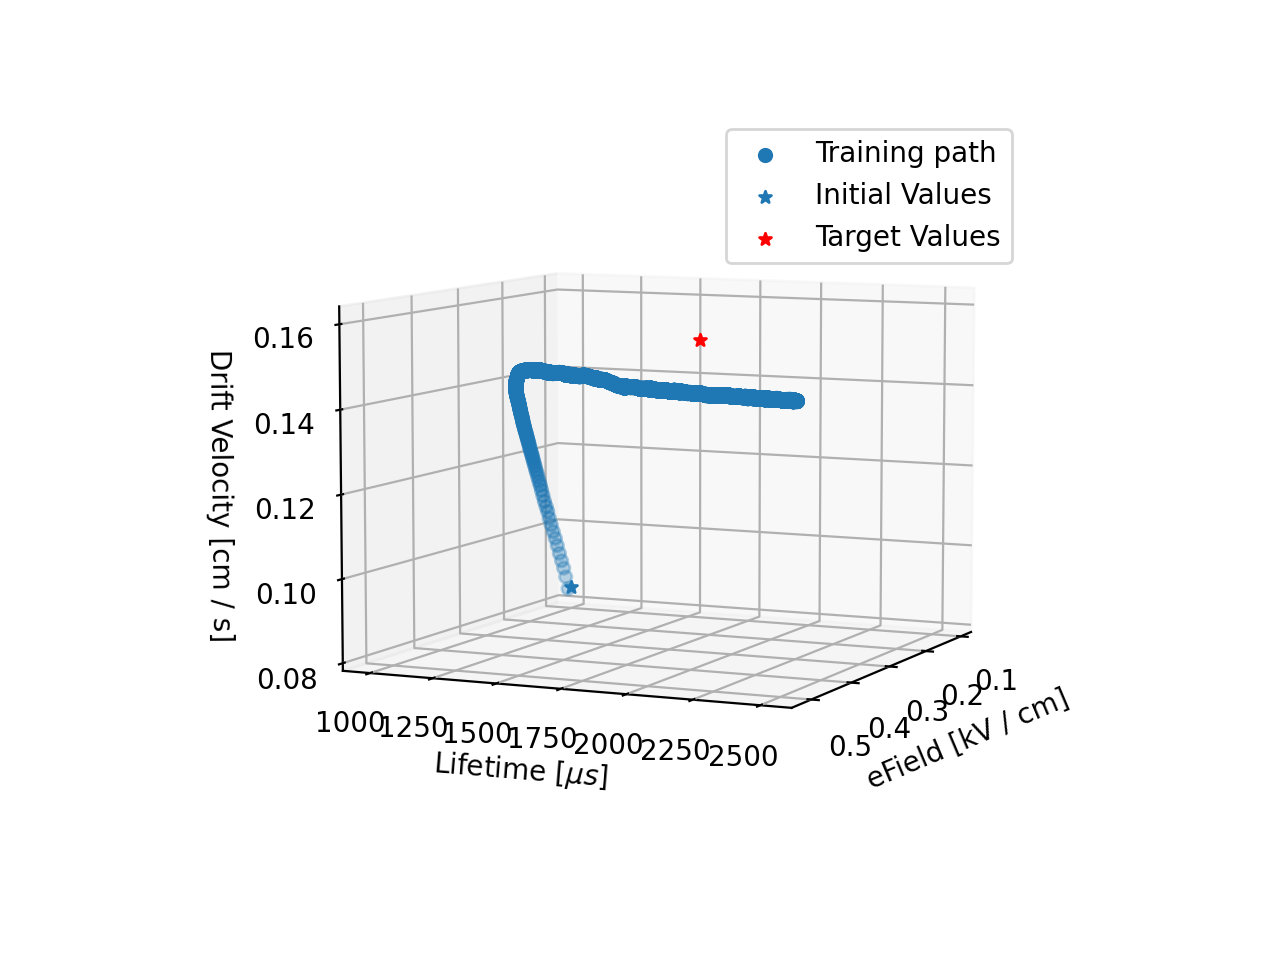

In [24]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(training_step_eFields, training_step_lifetimes, training_step_vdrifts,
        label='Training path')
ax.scatter(eField_init, lifetime_init, velocity(torch.tensor(eField_init).cpu()), c='C0', marker='*', label='Initial Values')
ax.scatter(0.5, 2200, 0.1587, marker='*', c='r', label='Target Values')
ax.set_xlabel('eField [kV / cm]', x=1.0, ha='right')
ax.set_ylabel('Lifetime [$\\mu s$]', y=1.0, ha='right')
ax.set_zlabel('Drift Velocity [cm / s]', y=1.0, ha='right')
plt.legend()
#pickle.dump(fig, open('3param_fit_path.pickle', 'wb'))
plt.show()